# Predicting house prices with advanced regression models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
%matplotlib inline

In [3]:
sns.set() ## set Seaborn defaults

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Exploratory data analysis

- First, let us take a close look at the correlations between the predictor variables and the target variable.

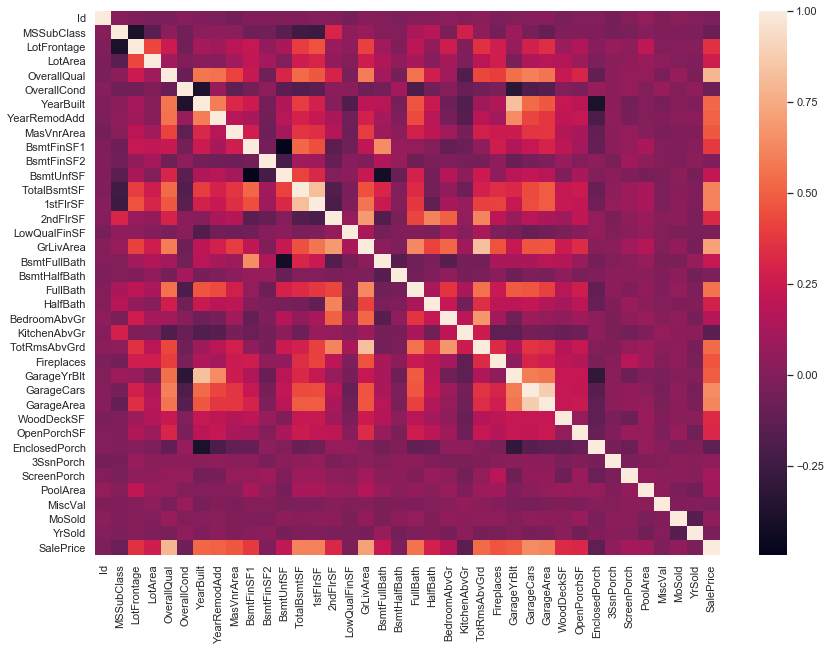

In [7]:
# Correlation matrix
plt.figure(figsize=(14,10))
sns.heatmap(train.corr())  ## only for numerical features

What is interesting in the above plot is the last row, i.e. `SalePrice`. We notice quite a few red squares there which signifies high correlation. These features will have the the highest predictive power in our ML models. We will now take a detailed look at these features. 

Note: One can see two 2x2 white squares along the diagonal. It implies that the pairs `TotalBsmtSF` & `1stFlrSF`, and `GarageCars` & `GarageArea` are highly correlated, which is a sign of **collinearity**. 

In [8]:
train.corr()['SalePrice'].sort_values(ascending=False)[1:]

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

#### What we will do now is to do an exploratory analysis of those features which show the *strongest correlation* with our target variable `SalePrice`.

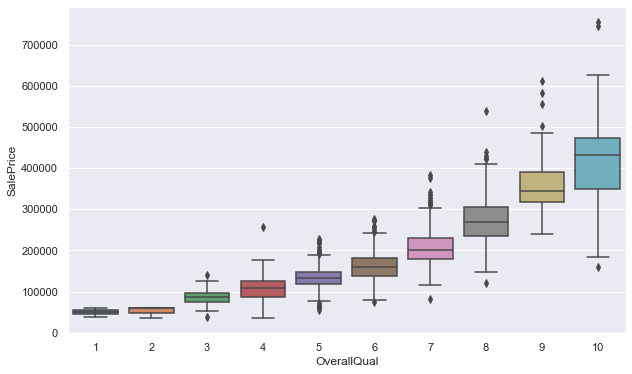

In [9]:
plt.figure(figsize=(10,6))
sns.boxplot(x=train['OverallQual'],y = train['SalePrice'])


Such a nice relationship! Up to `OVerallQual` = 6 it hs a relatively gentle slope, but in the regime `OVerallQual` > 6, `SalePrice` really takes off and shows a steeper trend. One can tell that this will be one of the strong predictor variables while analyzing feature importances. I believe that this feature is a combination of other predictor variables in the dataset and therefore we get such a smooth and clean relationship.

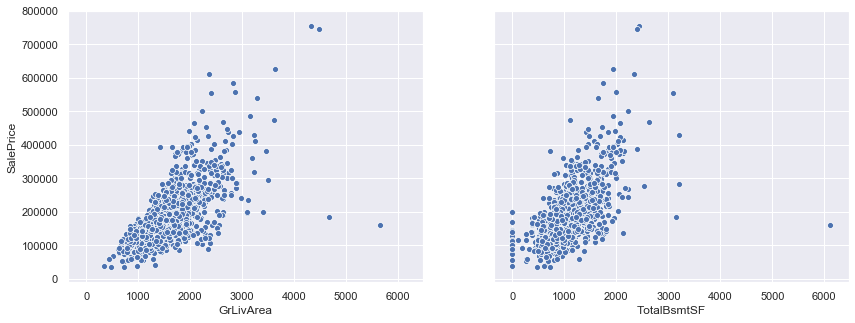

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey= True,sharex=True)
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'],ax=axs[0])
sns.scatterplot(train['TotalBsmtSF'],train['SalePrice'], ax=axs[1])

As expected, both `TotalBsmtSF` and `GrLivArea` show strong linear correlation with `SalePrice`. Furthermore, `SalePrice` shows a steeper relationship with `TotalBsmtSF` (both plots are drawn on the same scale).

Text(0.5, 1.0, 'Histogram of GrLivArea and TotalBsmtSF')

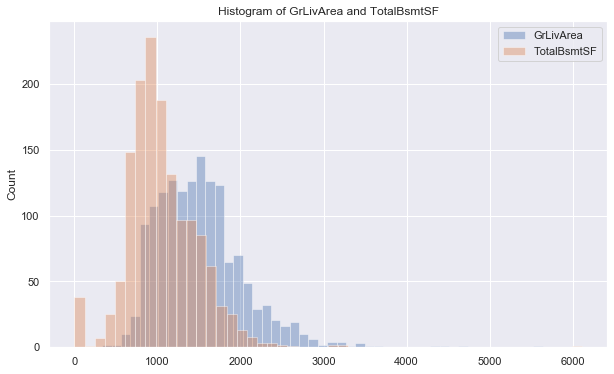

In [11]:
plt.figure(figsize=(10,6))
sns.distplot(train['GrLivArea'], label = 'GrLivArea',kde=False)
sns.distplot(train['TotalBsmtSF'], label = 'TotalBsmtSF',kde=False)
plt.legend()
plt.xlabel('')
plt.ylabel('Count')
plt.title('Histogram of GrLivArea and TotalBsmtSF')

Both **GrLivArea** and **TotalBsmtSF** show positive skewness. We will do the normality tests later in the notebook.

### Removing outliers

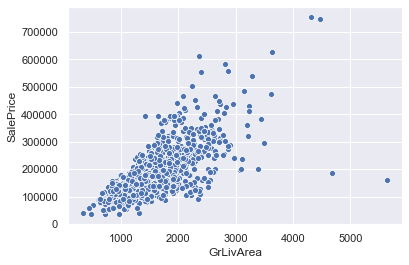

In [12]:
sns.scatterplot(train['GrLivArea'], train['SalePrice'])

- As evident from the living area vs. SalePrice plot, there are 2 clear outliers that one would wish to remove as part of the data cleaning process before proceeding to the modelling section. The [paper](http://jse.amstat.org/v19n3/decock.pdf) which introduced this dataset recommends removing all the 4 data points in the training set which has more than 4000 sqft of living area. But I chose to remove only those two points which correspond to huge houses priced rather inappropriately.

In [13]:
outliers_index = train.loc[train['GrLivArea']>4500, :].index
train = train.drop(outliers_index)
target = train['SalePrice']  ## target variable that we need to predict

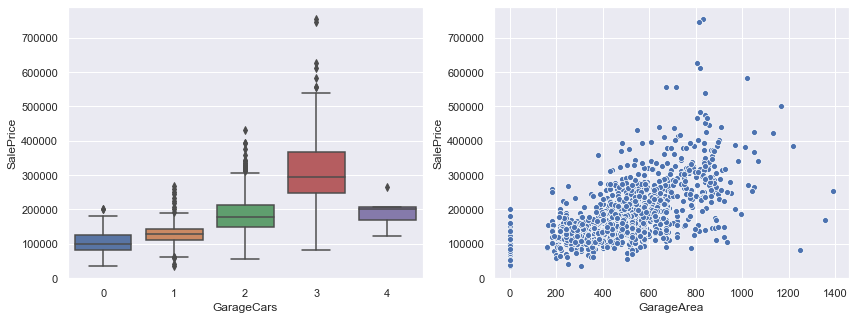

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.boxplot(x=train['GarageCars'], y=target,ax=axs[0])
sns.scatterplot(x=train['GarageArea'],y=target,ax=axs[1])

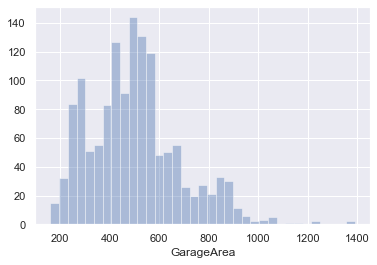

In [15]:
sns.distplot(train.loc[train['GarageArea']>0, 'GarageArea'],kde=False)

In [16]:
train['GarageCars'].value_counts()
#train.groupby('GarageCars').size()

2    823
1    369
3    180
0     81
4      5
Name: GarageCars, dtype: int64

In [17]:
train['YearBuilt'].describe()

count    1458.000000
mean     1971.218107
std        30.193754
min      1872.000000
25%      1954.000000
50%      1972.500000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

Text(0, 0.5, 'Count')

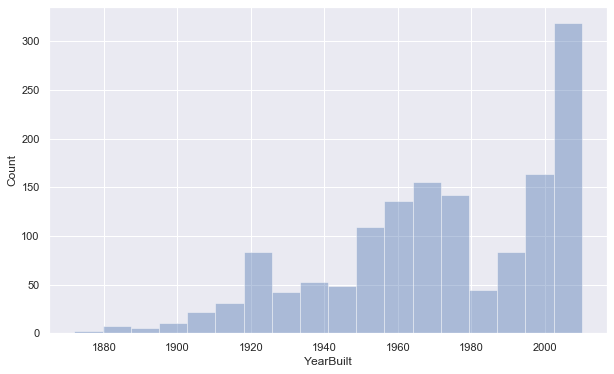

In [18]:
plt.figure(figsize=(10,6))
sns.distplot(train['YearBuilt'],kde=False)
plt.ylabel('Count')

50% of the houses sold were constructed after 1973, i.e. within the last 4 decades of the dataset. It is probably not a surprise considering the fact that the dataset contains sales data from 2006 to 2010 only. You are much less likely to buy a hundred-year old house.

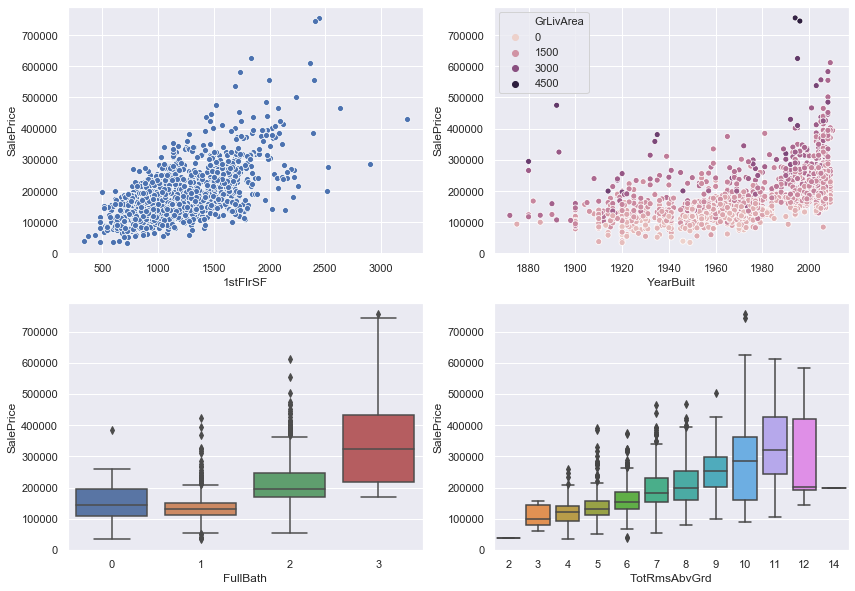

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
sns.scatterplot(x=train['1stFlrSF'], y=train['SalePrice'],ax=axs[0][0])
sns.scatterplot(x=train['YearBuilt'], y=train['SalePrice'],hue=train['GrLivArea'] ,ax=axs[0][1])
sns.boxplot(train['FullBath'],train['SalePrice'], ax=axs[1][0])
sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'],ax=axs[1][1])

We can see a strong correlation between `1stFlrSF` and `SalePrice`. The correlation of SalePrice with YearBuilt has to be taken with a pich of salt since the sales data is only collected between 2006-2010. That's exactly why older houses fetch lower prices with the exception of very big houses (living area is colour-coded in the figure).

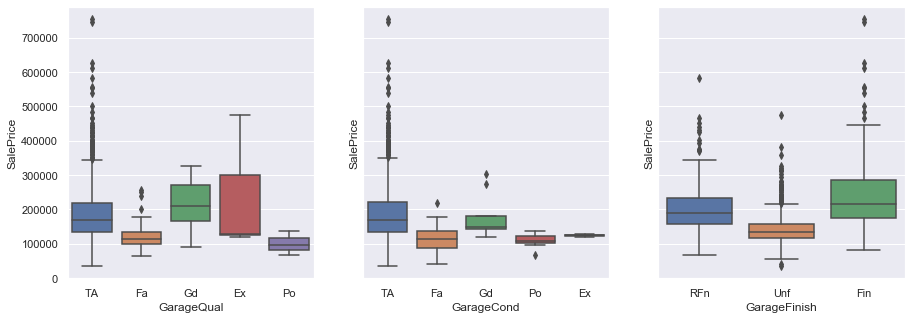

In [20]:
garage_cat_cols = ['GarageQual', 'GarageCond','GarageFinish']
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i in range(len(garage_cat_cols)):
    sns.boxplot(x=train[garage_cat_cols[i]],y=target,ax=axs[i])


While looking at the boxplots, it is worthwhile to keep in mind the number of data points available in each category. Please have a look at the category-wise value counts in the table below.

Label explanation from the documentation:

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

In [21]:
pd.concat([train['GarageQual'].value_counts(),train['GarageCond'].value_counts()],axis=1,sort=True)

,GarageQual,GarageCond
Ex,3,2
Fa,48,35
Gd,14,9
Po,3,7
TA,1309,1324


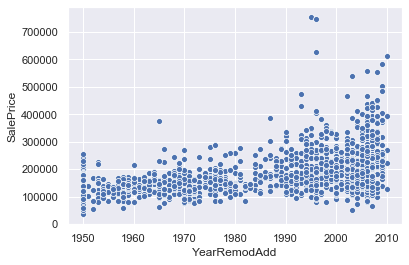

In [22]:
sns.scatterplot(train['YearRemodAdd'],train['SalePrice'])
# YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

Houses remodelled before 1990 does not seem to attract a high price. One is much better off buying a relatively recently remodelled house. 

Out of curiosity, I decided to check the OverallQual of all the remodelled houses. It's reassuring that recent houses are better rated overall (on average).

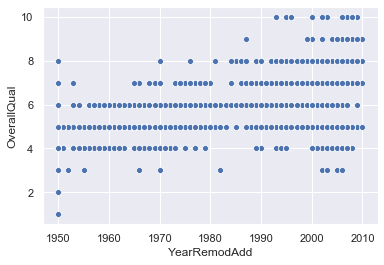

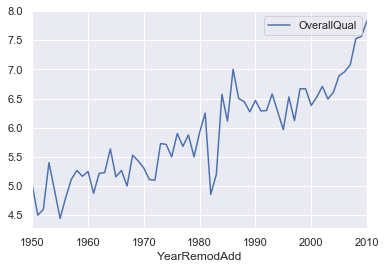

In [23]:
sns.scatterplot(train['YearRemodAdd'], train['OverallQual'])
train[['YearRemodAdd', 'OverallQual']].groupby('YearRemodAdd').mean().plot()
#train[['YearBuilt', 'OverallQual']].groupby('YearBuilt').mean().plot()

#### How does Neigbourhood influence SalePrice?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

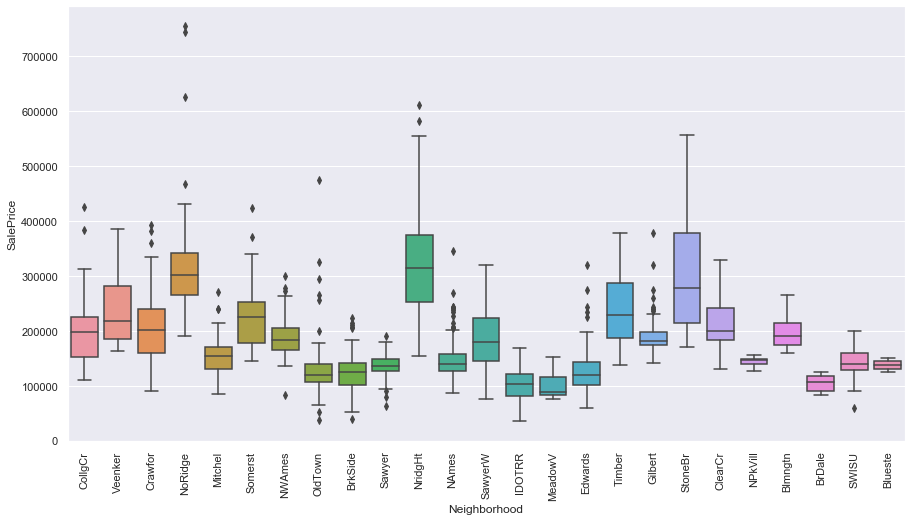

In [24]:
plt.figure(figsize=(15,8))
sns.boxplot(train['Neighborhood'], target)
plt.xticks(rotation='90')

It appears that **NoRidge** (Northridge), **NridgHt** (Northridge Heights) and **StoneBr** (Stone Brook) are the areas where the rich people of Ames prefer to stay.

### Missing values

In [25]:
train = train.drop(['SalePrice','Id'], axis=1)
test_id = test['Id']
test = test.drop('Id', axis=1)
full_data = pd.concat([train,test],axis=0,ignore_index=True)

In [26]:
def missing_data_df(df):
    '''Returns a pandas series showing which features of the input dataframe have missing values'''
    missing_df = df.isnull().sum(axis=0)
    missing_df =  missing_df[missing_df!=0]
    return missing_df

In [27]:
missing_train_test = pd.concat([train.isnull().sum(), test.isnull().sum(),full_data.isnull().sum()], axis=1, keys=['Train', 'Test', 'Full'], sort=True)
missing_train_test[missing_train_test.sum(axis=1) > 0]

,Train,Test,Full
Alley,1367,1352,2719
BsmtCond,37,45,82
BsmtExposure,38,44,82
BsmtFinSF1,0,1,1
BsmtFinSF2,0,1,1
BsmtFinType1,37,42,79
BsmtFinType2,38,42,80
BsmtFullBath,0,2,2
BsmtHalfBath,0,2,2
BsmtQual,37,44,81


Text(0.5, 1.0, 'Number of missing values in the (train + test) set')

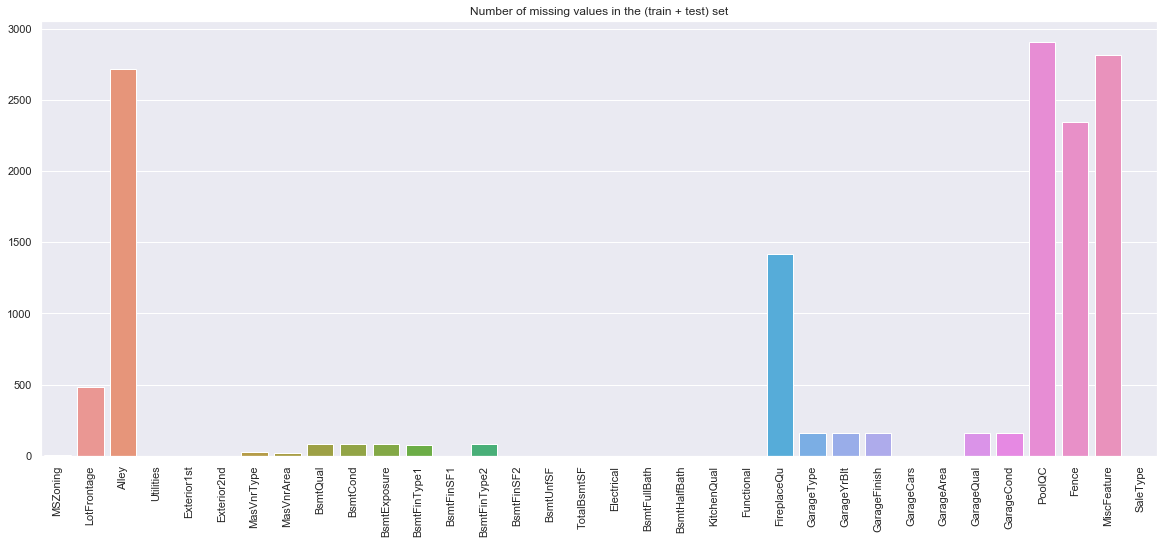

In [28]:
plt.figure(figsize=(20,8))
sns.barplot(x=missing_data_df(full_data).index,y = missing_data_df(full_data)) # How many missing values are there in the trainset?
plt.xticks(rotation='90')
plt.title('Number of missing values in the (train + test) set')

### Imputing missing values

- Numeric columns

In [29]:
num_cols = train.select_dtypes(include=[np.number]).columns
cat_cols = train.select_dtypes(exclude=[np.number]).columns

In [30]:
missing_data_df(full_data[num_cols])

LotFrontage     486
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt     159
GarageCars        1
GarageArea        1
dtype: int64

In [31]:
# This cell imputes missing values for numeric columns
fill_with_zero = ['MasVnrArea','GarageYrBlt','GarageArea', 'GarageCars']
fill_with_mean = ['LotFrontage','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
fill_with_mode = ['BsmtFullBath','BsmtHalfBath']

full_data.loc[:,fill_with_zero] = full_data[fill_with_zero].fillna(0)
full_data.loc[:,fill_with_mean] = full_data[fill_with_mean].fillna(train[fill_with_mean].mean())
for col in fill_with_mode:
    full_data[col] = full_data[col].fillna(train[col].mode()[0])

- Categorical columns

In [32]:
missing_data_df(full_data[cat_cols])

MSZoning           4
Alley           2719
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinType2      80
Electrical         1
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageFinish     159
GarageQual       159
GarageCond       159
PoolQC          2908
Fence           2346
MiscFeature     2812
SaleType           1
dtype: int64

In [33]:
# This cell imputes missing values for categorical columns

fill_with_mode_cat = ['MSZoning','MasVnrType','Electrical', 'KitchenQual','Functional', 'SaleType']
fill_with_none = ['Alley','Exterior1st', 'Exterior2nd','BsmtQual', 'BsmtCond', 
                  'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature' ]

full_data.loc[:,fill_with_none] = full_data[fill_with_none].fillna('None')
for col in fill_with_mode_cat:
    full_data[col] = full_data[col].fillna(train[col].mode()[0])

In [34]:
full_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

As you can see from the value counts above, all but one house does not have water connection (NoSeWa). Therefore, it makes no sense to keep the `Utilities` predictor.

In [35]:
full_data = full_data.drop('Utilities', axis=1)

In [36]:
print('Number of missing values present = %i' %np.sum(full_data.isnull().sum(axis=0)))

Number of missing values present = 0


### Feature engineering

- Add the total area of a house (including Garage) as a new predictor variable in out dataset

In [37]:
## Add the total area of a house (including Garage) as a new predictor variable in out dataset
full_data['total_area'] = full_data[['GrLivArea','TotalBsmtSF','GarageArea']].sum(axis=1)

- Since `GrLivArea` is the feature which seems to predict the `SalePrice` best, let's create a feature which is square of the living area.

In [38]:
full_data['GrLivArea_sq'] = full_data['GrLivArea']**2

- Total number of bathrooms might be a good choice? The half-bathrooms are weighted accordingly.

In [39]:
full_data['Total_bath'] = full_data['FullBath']+0.5*full_data['HalfBath']+full_data['BsmtFullBath']+0.5*full_data['BsmtHalfBath']

- Total porch area

In [40]:
full_data['Total_porchSF'] = full_data['WoodDeckSF']+full_data['OpenPorchSF']+full_data['EnclosedPorch']+full_data['3SsnPorch']+full_data['ScreenPorch']

In [41]:
np.corrcoef(full_data.loc[:len(target)-1,'Total_porchSF'], target)
#np.corrcoef(full_data.loc[0:len(target),'GrLivArea_sq'], target)

array([[1.        , 0.39289688],
       [0.39289688, 1.        ]])

Looks good! The correlation coefficient improved

In [42]:
full_data['yrs_since_renov'] = full_data['YearRemodAdd'] - full_data['YearBuilt']
full_data.loc[full_data['yrs_since_renov']<0, 'yrs_since_renov'] = 0

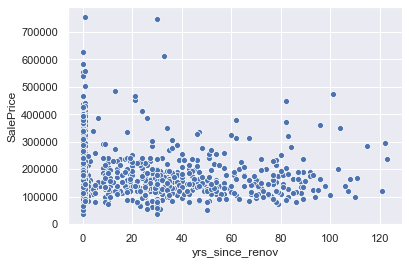

In [43]:
sns.scatterplot(full_data.loc[:len(train)-1, 'yrs_since_renov'], target)
#plt.ylim(0,3e5)

In [44]:
np.corrcoef(full_data.loc[:len(target)-1,'yrs_since_renov'], target)

array([[ 1.        , -0.21763489],
       [-0.21763489,  1.        ]])

In [45]:
num_cols = full_data.select_dtypes(include=[np.number]).columns
cat_cols = full_data.select_dtypes(exclude=[np.number]).columns

### Analying `SalePrice`: the target variable

[Text(0.5, 0, 'Normalized Sale price (z-scores)')]

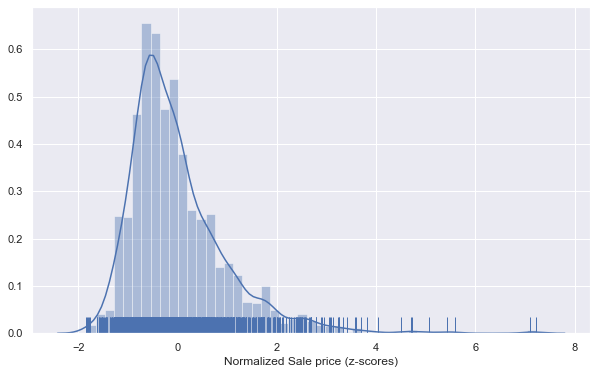

In [46]:
plt.figure(figsize=(10,6))
z = (target- np.mean(target))/np.std(target)
ax = sns.distplot(z,rug=True)
ax.set(xlabel = 'Normalized Sale price (z-scores)')

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74213.25959976624, 180932.91906721535, 0.9320154492892367))

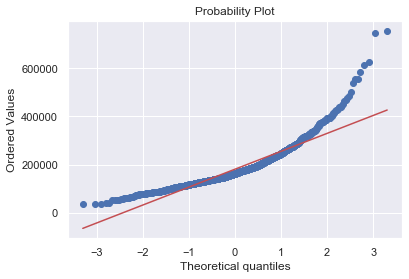

In [47]:
from scipy import stats
stats.probplot(target, plot=plt)

In [48]:
target = np.log(target)
# https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html

In [49]:
target.describe()

count    1458.000000
mean       12.024009
std         0.399715
min        10.460242
25%        11.774713
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'after transformation of SalePrice')

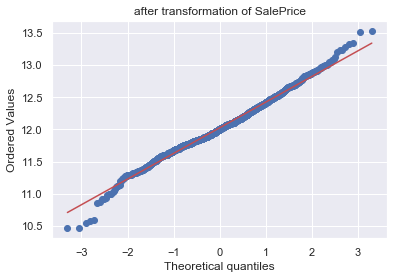

In [50]:
stats.probplot(target, plot=plt)
plt.title('after transformation of SalePrice')

### Analyzing skewed variables

- Let's look at the QQ plots of the highest correlated variables

((array([-3.48712442, -3.24243636, -3.10707149, ...,  3.10707149,
          3.24243636,  3.48712442]),
  array([ 105.,  160.,  173., ..., 3200., 3206., 5095.])),
 (386.6273694083876, 1078.1583434438314, 0.9716586471496782))

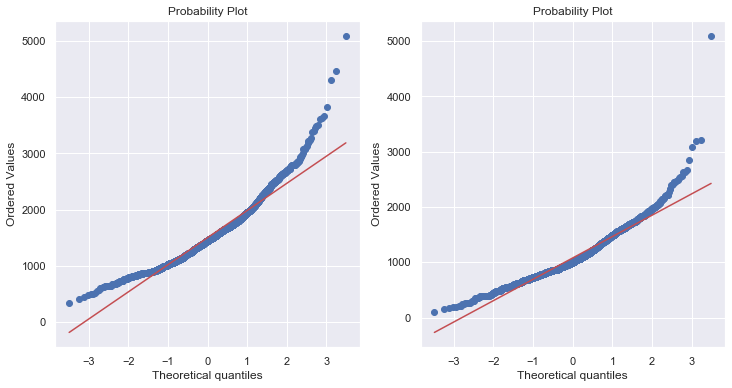

In [51]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
stats.probplot(full_data.loc[full_data['GrLivArea']>0, 'GrLivArea'], plot=ax[0])
stats.probplot(full_data.loc[full_data['TotalBsmtSF']>0, 'TotalBsmtSF'], plot=ax[1])

- After log transformation

Text(0.5, 1.0, 'TotalBsmtSF after Log transform')

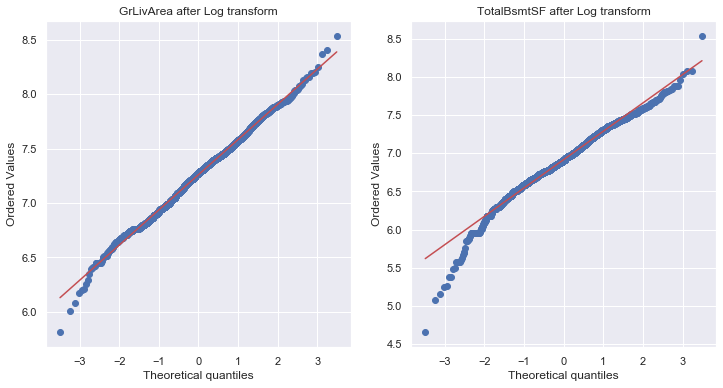

In [52]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
stats.probplot(np.log(full_data.loc[full_data['GrLivArea']>0, 'GrLivArea']), plot=ax[0])
stats.probplot(np.log(full_data.loc[full_data['TotalBsmtSF']>0, 'TotalBsmtSF']), plot=ax[1])
ax[0].set_title('GrLivArea after Log transform')
ax[1].set_title('TotalBsmtSF after Log transform')

In [53]:
skew_list = []
for num_col in num_cols:
    skew_list.append([num_col, full_data[num_col].skew()])
skew_df = pd.DataFrame(skew_list, columns=['Feature', 'Skewness']).sort_values(by='Skewness', ascending=False).reset_index()
skew_df.head()

,index,Feature,Skewness
0,33,MiscVal,21.950962
1,32,PoolArea,17.697766
2,2,LotArea,13.116240
3,14,LowQualFinSF,12.090757
4,30,3SsnPorch,11.377932


((array([-1.93807102, -1.52350933, -1.27167259, -1.08178602, -0.92453898,
         -0.78737238, -0.66363796, -0.54932825, -0.44179391, -0.33915032,
         -0.23996855, -0.143098  , -0.04755496,  0.04755496,  0.143098  ,
          0.23996855,  0.33915032,  0.44179391,  0.54932825,  0.66363796,
          0.78737238,  0.92453898,  1.08178602,  1.27167259,  1.52350933,
          1.93807102]),
  array([ 53,  80,  80,  80, 120, 144, 156, 205, 232, 234, 360, 360, 371,
         384, 390, 392, 397, 420, 473, 479, 481, 513, 514, 515, 528, 572])),
 (167.89753125051496, 328.1923076923077, 0.9620762193707233))

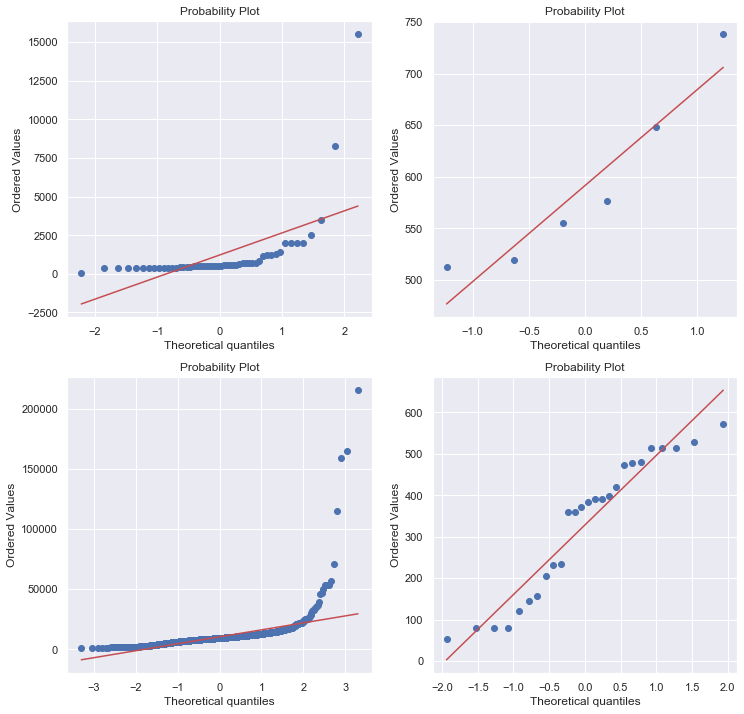

In [54]:
fig,ax = plt.subplots(2,2,figsize=(12,12))
stats.probplot(train.loc[train['MiscVal']>0, 'MiscVal'], plot=ax[0][0])
stats.probplot(train.loc[train['PoolArea']>0, 'PoolArea'], plot=ax[0][1])
stats.probplot(train.loc[train['LotArea']>0, 'LotArea'], plot=ax[1][0])
stats.probplot(train.loc[train['LowQualFinSF']>0, 'LowQualFinSF'], plot=ax[1][1])

In [55]:
skew_gtr1_list = list(skew_df.loc[np.abs(skew_df['Skewness'])>0.8,'Feature'])

In [56]:
full_data.loc[:, skew_gtr1_list] = full_data.loc[:, skew_gtr1_list].apply(np.log1p)

## Encoding categorical features

In [57]:
ordinal_cat_cols = ['Alley', 'Street',  'LandSlope', 'LotShape',
                    'ExterQual', 'ExterCond','BsmtQual', 'BsmtCond', 'BsmtExposure',
                    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir',
                     'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
                    'GarageQual','GarageCond','PavedDrive', 'PoolQC', 'Fence', 'GarageType', 'HouseStyle', 'Electrical']


nominal_cat_cols = [ 'MSZoning', 'LandContour', 'LotConfig', 
                    'Neighborhood', 'Condition1', 'Condition2', 
                    'BldgType', 'RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
                    'Foundation', 'Heating', 'MiscFeature', 'SaleType', 'SaleCondition']

In [58]:
len(ordinal_cat_cols) + len(nominal_cat_cols) == len(cat_cols)

True

### Label Encoding ordinal categorical variables

In [59]:
enc =LabelEncoder()
full_data[ordinal_cat_cols] = full_data[ordinal_cat_cols].apply(enc.fit_transform)
#for ordinal_cat_col in ordinal_cat_cols:
#    enc = LabelEncoder()
#    train_copy.loc[:,ordinal_cat_col] = enc.fit_transform(train[ordinal_cat_col])
#    test_copy.loc[:,ordinal_cat_col] = enc.transform(test[ordinal_cat_col])

### Feature scaling numeric features

In [60]:
num_cols = full_data.select_dtypes(include=[np.number]).columns

In [61]:
train = full_data.iloc[:len(train)]  
test  = full_data.iloc[len(train):]

In [62]:
scaler = RobustScaler()
train_copy = train.copy()
test_copy = test.copy()
train_copy.loc[:,num_cols] = scaler.fit_transform(train[num_cols])
test_copy.loc[:,num_cols] = scaler.transform(test[num_cols])
train = train_copy
test = test_copy
full_data = pd.concat([train,test], axis=0,ignore_index=True)

### One-Hot Encoding nominal categorical variables

In [63]:
full_data = pd.get_dummies(full_data,drop_first=False)
print('The shape of the data matrix after pre-processing: {}' .format(full_data.shape))

The shape of the data matrix after pre-processing: (2917, 209)


In [64]:
#Removing highly correlated predictors
#full_data = full_data.drop(['GarageArea', '1stFlrSF', 'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'], axis=1)

In [65]:
train= full_data.iloc[:len(train)]
test = full_data.iloc[len(train):]

In [66]:
print(train.shape) # 'Id' column dropped
print(test.shape)

(1458, 209)
(1459, 209)


## Regression models

In [67]:
from sklearn.model_selection import train_test_split, KFold

In [68]:
# Split the dataset into training and dev set
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=123)

## Linear models

In [69]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error as mse

### Lasso

In [70]:
alpha_list_lasso = [1e-5,5e-5,8e-5,1e-4, 5e-4,1e-3, 1e-2,0.1]

training_score = []
test_score = []
feature_selection = []
for alpha in alpha_list_lasso:
    lasso = Lasso(alpha = alpha,max_iter=2e4)
    lasso.fit(X_train, y_train)
    training_score.append(lasso.score(X_train, y_train))  # This score is R_squared
    test_score.append(lasso.score(X_test,y_test))
    feature_selection.append(np.sum(lasso.coef_!=0))

Text(0, 0.5, '# of features selected')

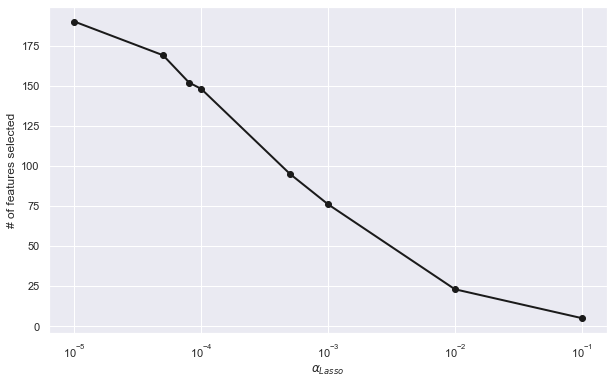

In [71]:
plt.figure(figsize=(10,6))
plt.semilogx(alpha_list_lasso, feature_selection, 'ko-',lw=2)
plt.xlabel(r'$\alpha_{Lasso}$')
plt.ylabel('# of features selected')

In [72]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)

In [73]:
val_sc_mean = []
for alpha in alpha_list_lasso:
    model = Lasso(alpha = alpha, random_state=10,max_iter=1e5)
    val_sc = cross_val_score(model,X_train,y_train,cv=kf,scoring='neg_mean_squared_error')
    val_sc_mean.append(np.mean(np.sqrt(np.abs(val_sc))))
    
index = val_sc_mean.index(np.min(val_sc_mean))
print('\nThe best mean CV score (rmse)=  %.7f which corresponds to alpha = %.4f' 
      %(np.min(val_sc_mean), alpha_list_lasso[index])) 
pd.DataFrame(zip(alpha_list_lasso,val_sc_mean),columns=['alpha','Mean CV score (RMSE)'])


The best mean CV score (rmse)=  0.1130348 which corresponds to alpha = 0.0005


,alpha,Mean CV score (RMSE)
0,0.00001,0.124665
1,0.00005,0.120504
2,0.00008,0.118632
3,0.00010,0.117649
4,0.00050,0.113035
5,0.00100,0.115347
6,0.01000,0.130780
7,0.10000,0.228018


Text(0.5, 1.0, 'Lasso regression')

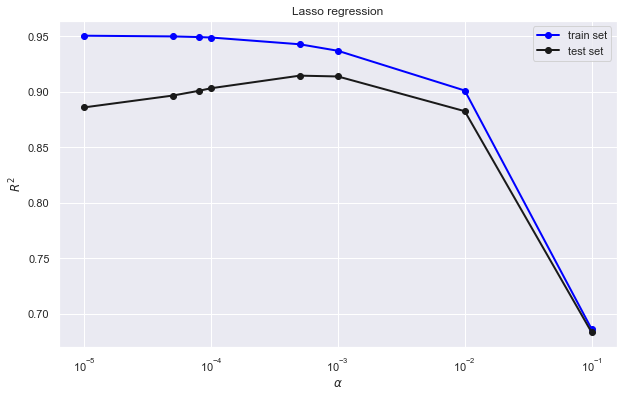

In [74]:
plt.figure(figsize=(10,6))
plt.semilogx(alpha_list_lasso,training_score, marker='o',color='blue', lw=2, label='train set')
plt.semilogx(alpha_list_lasso,test_score, 'ko-', lw=2, label='test set')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^{2}$')
plt.legend()
plt.title('Lasso regression')

In [106]:
lasso_final = Lasso(alpha = 0.0005, random_state=10,max_iter=5000)
lasso_final.fit(X_train,y_train)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=5000,
      normalize=False, positive=False, precompute=False, random_state=10,
      selection='cyclic', tol=0.0001, warm_start=False)

In [76]:
coef = pd.Series(lasso_final.coef_, index = X_train.columns)

In [77]:
imp_coef = pd.concat([coef.sort_values(ascending=False).head(10),
                     coef.sort_values(ascending=False).tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

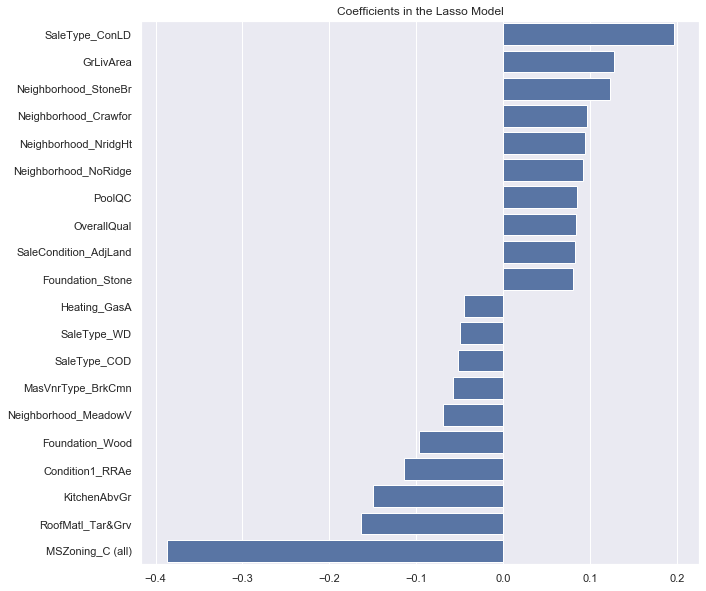

In [78]:
plt.figure(figsize=(10,10))
sns.barplot(imp_coef.values, imp_coef.index,  orient='h',color='b')
plt.title("Coefficients in the Lasso Model")

### Ridge regression

In [79]:
alpha_list_ridge = [0.01,0.1,0.6, 1,1.5, 2, 3,  5, 7, 8, 10,15,20]

validation_score_mean = []
for alpha in alpha_list_ridge:
    validation_score = cross_val_score(Ridge(alpha = alpha, solver='svd',
                                             random_state=123,max_iter=5000),X_train,y_train,cv=5,scoring='neg_mean_squared_error')
    validation_score_mean.append(np.mean(np.sqrt(np.abs(validation_score))))
#    print('alpha = ', alpha, 'mean CV score = ', validation_score_mean[-1])

index = np.where(validation_score_mean == np.min(validation_score_mean))[0][0]
print('\nThe best mean CV score (rmse)=  %.7f which corresponds to alpha = %.1f' 
      %(np.min(validation_score_mean), alpha_list_ridge[index])) 

pd.DataFrame(zip(alpha_list_ridge,validation_score_mean),columns=['alpha','Mean CV score (RMSE)'])    


The best mean CV score (rmse)=  0.1130653 which corresponds to alpha = 5.0


,alpha,Mean CV score (RMSE)
0,0.01,0.121952
1,0.10,0.119959
2,0.60,0.115841
3,1.00,0.114681
4,1.50,0.113952
5,2.00,0.113565
6,3.00,0.113213
7,5.00,0.113065
8,7.00,0.113121
9,8.00,0.113174


Text(0.5, 1.0, 'Ridge regression')

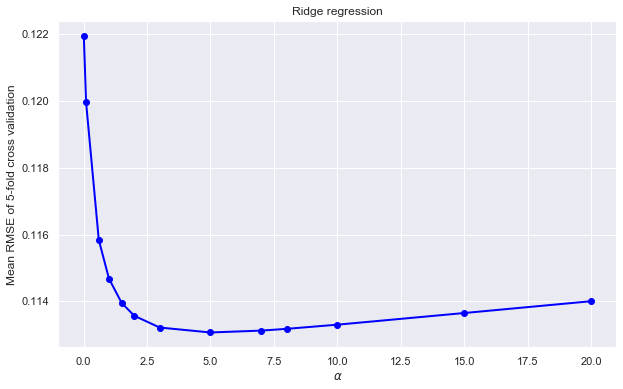

In [80]:
plt.figure(figsize=(10,6))
plt.plot(alpha_list_ridge,validation_score_mean, marker='o',color='blue', lw=2)
plt.xlabel('$\\alpha$')
plt.ylabel('Mean RMSE of 5-fold cross validation')
plt.title('Ridge regression')

Text(0.5, 1.0, 'Ridge regression')

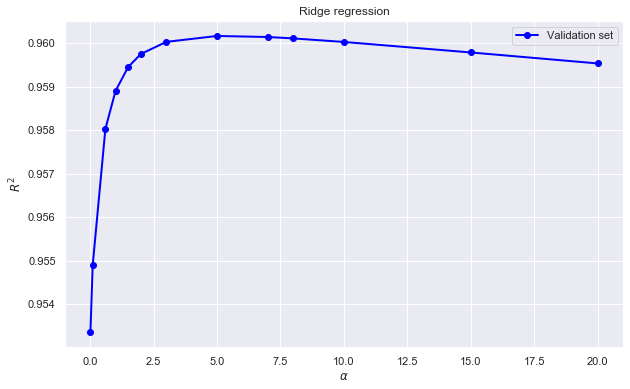

In [81]:
validation_score_r2_mean = []
for alpha in alpha_list_ridge:
    validation_score_r2 = cross_val_score(Ridge(alpha = alpha, solver='svd',
                                             random_state=123,max_iter=5000),X_train,y_train,cv=5,scoring='r2')
    train_score_r2 = Ridge(alpha = alpha, solver='svd',
                                             random_state=123,max_iter=5000)
    validation_score_r2_mean.append(np.mean(np.sqrt(np.abs(validation_score_r2))))

plt.figure(figsize=(10,6))
plt.plot(alpha_list_ridge,validation_score_r2_mean, marker='o',color='blue', lw=2, label='Validation set')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^{2}$')
plt.legend()
plt.title('Ridge regression')


In [82]:
## test exercise to verify the realtion between R^2 and mse.

#ridge_ex = Ridge(alpha = 1)
#ridge_ex.fit(X_train, y_train)
#TSS = np.sum(((y_train - y_train.mean())**2).values)
#SSE = np.sum((ridge_ex.predict(X_train) - y_train)**2)
#R_squared = ridge_ex.score(X_train, y_train)
#R_squared -1 +SSE/TSS

In [83]:
ridge_final = Ridge(alpha = 5, random_state=123,max_iter=5000)
ridge_final.fit(X_train,y_train)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=5000, normalize=False,
      random_state=123, solver='auto', tol=0.001)

### Elastic net

In [84]:
#If a is L1 coefficient and b is L2 coefficient, then alpha = a + b and l1_ratio = a / (a + b)

alpha_list_enet = [ 5e-4, 0.001, 0.005, 0.01, 0.05, 0.1,0.5,1]

validation_score_mean = []
for alpha in alpha_list_enet:
    validation_score = cross_val_score(ElasticNet(alpha = alpha, l1_ratio = 0.3,
                                             random_state=123,max_iter=50000),X_train,y_train,cv=5,scoring='neg_mean_squared_error')
    validation_score_mean.append(np.mean(np.sqrt(np.abs(validation_score))))

index = np.where(validation_score_mean == np.min(validation_score_mean))[0][0]
print('\nThe best mean CV score (rmse)=  %.7f which corresponds to alpha = %.4f' 
      %(np.min(validation_score_mean), alpha_list_enet[index])) 
pd.DataFrame(zip(alpha_list_enet,validation_score_mean),columns=['alpha','Mean CV score (RMSE)'])        


The best mean CV score (rmse)=  0.1121898 which corresponds to alpha = 0.0010


,alpha,Mean CV score (RMSE)
0,0.0005,0.113139
1,0.0010,0.112190
2,0.0050,0.118258
3,0.0100,0.122500
4,0.0500,0.136123
5,0.1000,0.156498
6,0.5000,0.294090
7,1.0000,0.351204


Text(0.5, 1.0, 'Elastic net regression')

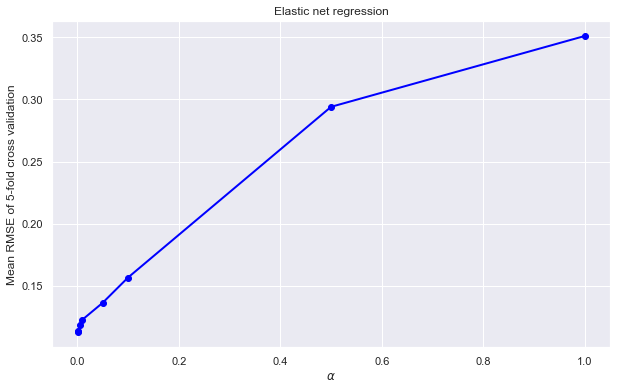

In [85]:
plt.figure(figsize=(10,6))
plt.plot(alpha_list_enet,validation_score_mean, marker='o',color='blue', lw=2)
plt.xlabel('$\\alpha$')
plt.ylabel('Mean RMSE of 5-fold cross validation')
plt.title('Elastic net regression')

In [86]:
def grid_search(clf, parameters, X, y, n_jobs= -1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func,verbose =2)
    else:
        print('Doing grid search')
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose =2)
    gs.fit(X, y)
    print("mean test score (weighted by split size) of CV rounds [RMSE]: ",np.sqrt(abs(gs.cv_results_['mean_test_score'])))
    print ("\nBest parameter set", gs.best_params_, "Corresponding mean CV score (rmse)",np.sqrt(abs(gs.best_score_)))
    best = gs.best_estimator_
    return best

In [87]:
enet_gs = ElasticNet(random_state=13,max_iter=50000)
param = {
'alpha' : [1e-4,5e-4, 0.001, 0.005, 0.01, 0.05, 0.1],
'l1_ratio': [0.1,0.3,0.5,0.7]
}
enet_gs  = grid_search(enet_gs, param,X_train,y_train, n_folds=5, score_func= 'neg_mean_squared_error')

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   58.1s finished


mean test score (weighted by split size) of CV rounds [RMSE]:  [0.11968095 0.11816111 0.11721143 0.11644047 0.11527501 0.11339529
 0.11277025 0.11269046 0.11334822 0.11242304 0.11287019 0.11361912
 0.11361903 0.11876783 0.1220322  0.1238124  0.1164782  0.12313642
 0.12601519 0.1286373  0.12730761 0.13695816 0.14960995 0.16236357
 0.13423256 0.15748098 0.17886874 0.19728384]

Best parameter set {'alpha': 0.001, 'l1_ratio': 0.3} Corresponding mean CV score (rmse) 0.11242303761476301


In [107]:
enet_final = ElasticNet(alpha=.001,l1_ratio=0.3, max_iter=50000)
enet_final.fit(X_train, y_train)

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.3,
           max_iter=50000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

### XGBoost

In [89]:
def rmsle(log_pred, log_actual):
    log_pred = np.array([np.log(val + 1) for val in log_pred])
    log_actual = np.array([np.log(val + 1) for val in log_actual])
    logsqerror = (log_pred - log_actual) ** 2
    return np.sqrt(np.mean(logsqerror))

In [90]:
from xgboost.sklearn import XGBRegressor

In [91]:
param = {}
param['learning_rate'] = 0.05
param['verbosity'] = 1
param['colsample_bylevel'] = 0.7
param['colsample_bytree'] = 0.8
param['subsample'] = 0.6
param['reg_lambda']= 1.5
param['max_depth'] = 3
param['n_estimators'] = 800
param['seed']= 10
param['min_child_weight'] = 4
#param['gamma'] = 0.05
xgb= XGBRegressor(**param)
xgb.fit(X_train, y_train, eval_metric=['rmse'], eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds=40)

[0]	validation_0-rmse:10.9563	validation_1-rmse:10.9588
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 40 rounds.
[1]	validation_0-rmse:10.4109	validation_1-rmse:10.4133
[2]	validation_0-rmse:9.89265	validation_1-rmse:9.89501
[3]	validation_0-rmse:9.40101	validation_1-rmse:9.40331
[4]	validation_0-rmse:8.93338	validation_1-rmse:8.93564
[5]	validation_0-rmse:8.4891	validation_1-rmse:8.4913
[6]	validation_0-rmse:8.0663	validation_1-rmse:8.06844
[7]	validation_0-rmse:7.66453	validation_1-rmse:7.66661
[8]	validation_0-rmse:7.28312	validation_1-rmse:7.28514
[9]	validation_0-rmse:6.92123	validation_1-rmse:6.92318
[10]	validation_0-rmse:6.5777	validation_1-rmse:6.57957
[11]	validation_0-rmse:6.2522	validation_1-rmse:6.254
[12]	validation_0-rmse:5.94169	validation_1-rmse:5.94341
[13]	validation_0-rmse:5.64608	validation_1-rmse:5.64771
[14]	validation_0-rmse:5.36623	validation_1-rmse:5.36778
[15

[138]	validation_0-rmse:0.098517	validation_1-rmse:0.122145
[139]	validation_0-rmse:0.098283	validation_1-rmse:0.12205
[140]	validation_0-rmse:0.098001	validation_1-rmse:0.121875
[141]	validation_0-rmse:0.097656	validation_1-rmse:0.121842
[142]	validation_0-rmse:0.097404	validation_1-rmse:0.121626
[143]	validation_0-rmse:0.097161	validation_1-rmse:0.121417
[144]	validation_0-rmse:0.096911	validation_1-rmse:0.1212
[145]	validation_0-rmse:0.096647	validation_1-rmse:0.121182
[146]	validation_0-rmse:0.096322	validation_1-rmse:0.121166
[147]	validation_0-rmse:0.096052	validation_1-rmse:0.121006
[148]	validation_0-rmse:0.095764	validation_1-rmse:0.120859
[149]	validation_0-rmse:0.095398	validation_1-rmse:0.120639
[150]	validation_0-rmse:0.095121	validation_1-rmse:0.120535
[151]	validation_0-rmse:0.094879	validation_1-rmse:0.120418
[152]	validation_0-rmse:0.094723	validation_1-rmse:0.120266
[153]	validation_0-rmse:0.094441	validation_1-rmse:0.120063
[154]	validation_0-rmse:0.094132	validation

[276]	validation_0-rmse:0.077126	validation_1-rmse:0.11632
[277]	validation_0-rmse:0.077069	validation_1-rmse:0.116298
[278]	validation_0-rmse:0.077005	validation_1-rmse:0.116356
[279]	validation_0-rmse:0.076954	validation_1-rmse:0.116319
[280]	validation_0-rmse:0.076894	validation_1-rmse:0.116299
[281]	validation_0-rmse:0.076762	validation_1-rmse:0.116271
[282]	validation_0-rmse:0.076561	validation_1-rmse:0.116405
[283]	validation_0-rmse:0.076465	validation_1-rmse:0.116439
[284]	validation_0-rmse:0.076387	validation_1-rmse:0.116403
[285]	validation_0-rmse:0.076331	validation_1-rmse:0.116324
[286]	validation_0-rmse:0.076216	validation_1-rmse:0.11632
[287]	validation_0-rmse:0.076063	validation_1-rmse:0.116376
[288]	validation_0-rmse:0.07592	validation_1-rmse:0.11647
[289]	validation_0-rmse:0.075851	validation_1-rmse:0.116468
[290]	validation_0-rmse:0.075732	validation_1-rmse:0.116531
[291]	validation_0-rmse:0.075647	validation_1-rmse:0.116419
[292]	validation_0-rmse:0.075578	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
             colsample_bytree=0.8, gamma=0, learning_rate=0.05,
             max_delta_step=0, max_depth=3, min_child_weight=4, missing=None,
             n_estimators=800, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1,
             seed=10, silent=True, subsample=0.6, verbosity=1)

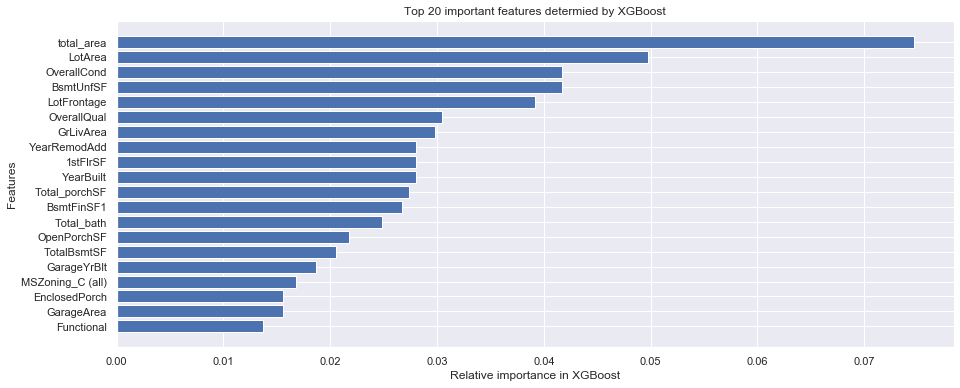

In [92]:
xgb_imp_df = pd.DataFrame({'feature_imp':xgb.feature_importances_, 'Feature_name': X_train.columns}).sort_values(by='feature_imp', ascending=False).iloc[:20]
plt.figure(figsize=(15,6))
plt.barh(xgb_imp_df['Feature_name'][::-1],xgb_imp_df['feature_imp'][::-1],align='center')
plt.xlabel('Relative importance in XGBoost')
plt.ylabel('Features')
plt.title('Top 20 important features determied by XGBoost')
plt.show()

In [93]:
xgbgrid_search = XGBRegressor()
param = {
'learning_rate': [0.05],#[0.1,0.2],
#'verbosity': [1],
'colsample_bylevel': [0.7,0.8],
'colsample_bytree': [0.7,0.8],
'subsample' : [0.6,0.7], #0.8
'n_estimators': [500],
'reg_lambda': [2.5], #1.5,2,
'max_depth': [2,3],#4
 'min_child_weight': [1,2,4],   
 'seed': [10]   
}
xgbCV  = grid_search(xgbgrid_search, param,X_train,y_train, n_folds=4, score_func= 'neg_mean_squared_error')

Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  1.7min finished


mean test score (weighted by split size) of CV rounds [RMSE]:  [0.11924369 0.12090508 0.12102616 0.12233463 0.12221243 0.12261333
 0.12432645 0.12072627 0.12071641 0.12180279 0.12231428 0.12191648
 0.12124166 0.12043514 0.12114284 0.12113945 0.12268953 0.12185671
 0.12422327 0.12235922 0.1208046  0.12215376 0.1233937  0.12352481
 0.11976578 0.1224132  0.12128966 0.12240041 0.12224403 0.12230819
 0.12142631 0.12182128 0.12036312 0.12229071 0.12403709 0.12321449
 0.12099878 0.12135881 0.12058062 0.12117992 0.12219728 0.12221703
 0.12466018 0.12172169 0.12013632 0.12256685 0.12272856 0.12289936]

Best parameter set {'colsample_bylevel': 0.7, 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 500, 'reg_lambda': 2.5, 'seed': 10, 'subsample': 0.6} Corresponding mean CV score (rmse) 0.11924369158841056


In [94]:
xgbCV.fit(X_train, y_train, eval_metric=['rmse'], eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds=40)

[0]	validation_0-rmse:10.9572	validation_1-rmse:10.9597
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 40 rounds.
[1]	validation_0-rmse:10.4117	validation_1-rmse:10.4141
[2]	validation_0-rmse:9.8941	validation_1-rmse:9.89645
[3]	validation_0-rmse:9.40256	validation_1-rmse:9.40487
[4]	validation_0-rmse:8.93529	validation_1-rmse:8.93755
[5]	validation_0-rmse:8.49029	validation_1-rmse:8.49249
[6]	validation_0-rmse:8.06827	validation_1-rmse:8.07042
[7]	validation_0-rmse:7.66847	validation_1-rmse:7.67055
[8]	validation_0-rmse:7.28778	validation_1-rmse:7.28979
[9]	validation_0-rmse:6.92602	validation_1-rmse:6.92797
[10]	validation_0-rmse:6.58161	validation_1-rmse:6.58349
[11]	validation_0-rmse:6.25462	validation_1-rmse:6.25642
[12]	validation_0-rmse:5.94529	validation_1-rmse:5.94701
[13]	validation_0-rmse:5.64988	validation_1-rmse:5.65152
[14]	validation_0-rmse:5.37001	validation_1-rmse:5.371

[138]	validation_0-rmse:0.11475	validation_1-rmse:0.130915
[139]	validation_0-rmse:0.114446	validation_1-rmse:0.13082
[140]	validation_0-rmse:0.114042	validation_1-rmse:0.130427
[141]	validation_0-rmse:0.113691	validation_1-rmse:0.130226
[142]	validation_0-rmse:0.113348	validation_1-rmse:0.129987
[143]	validation_0-rmse:0.113016	validation_1-rmse:0.129813
[144]	validation_0-rmse:0.11262	validation_1-rmse:0.129435
[145]	validation_0-rmse:0.112293	validation_1-rmse:0.129113
[146]	validation_0-rmse:0.11191	validation_1-rmse:0.128784
[147]	validation_0-rmse:0.111633	validation_1-rmse:0.128653
[148]	validation_0-rmse:0.111304	validation_1-rmse:0.12836
[149]	validation_0-rmse:0.111074	validation_1-rmse:0.128185
[150]	validation_0-rmse:0.110828	validation_1-rmse:0.128028
[151]	validation_0-rmse:0.110527	validation_1-rmse:0.127809
[152]	validation_0-rmse:0.110286	validation_1-rmse:0.127589
[153]	validation_0-rmse:0.110088	validation_1-rmse:0.127531
[154]	validation_0-rmse:0.109869	validation_1

[276]	validation_0-rmse:0.092824	validation_1-rmse:0.118868
[277]	validation_0-rmse:0.092754	validation_1-rmse:0.118816
[278]	validation_0-rmse:0.092693	validation_1-rmse:0.118782
[279]	validation_0-rmse:0.092611	validation_1-rmse:0.118753
[280]	validation_0-rmse:0.092548	validation_1-rmse:0.118709
[281]	validation_0-rmse:0.092456	validation_1-rmse:0.118708
[282]	validation_0-rmse:0.09238	validation_1-rmse:0.118689
[283]	validation_0-rmse:0.092292	validation_1-rmse:0.11861
[284]	validation_0-rmse:0.092203	validation_1-rmse:0.118719
[285]	validation_0-rmse:0.092116	validation_1-rmse:0.118698
[286]	validation_0-rmse:0.092025	validation_1-rmse:0.118659
[287]	validation_0-rmse:0.091928	validation_1-rmse:0.118575
[288]	validation_0-rmse:0.09185	validation_1-rmse:0.11857
[289]	validation_0-rmse:0.091802	validation_1-rmse:0.118596
[290]	validation_0-rmse:0.091711	validation_1-rmse:0.118688
[291]	validation_0-rmse:0.091684	validation_1-rmse:0.118529
[292]	validation_0-rmse:0.091589	validation_

[413]	validation_0-rmse:0.084014	validation_1-rmse:0.116514
[414]	validation_0-rmse:0.083935	validation_1-rmse:0.116479
[415]	validation_0-rmse:0.083904	validation_1-rmse:0.116468
[416]	validation_0-rmse:0.083845	validation_1-rmse:0.116421
[417]	validation_0-rmse:0.08378	validation_1-rmse:0.116402
[418]	validation_0-rmse:0.083752	validation_1-rmse:0.116382
[419]	validation_0-rmse:0.083731	validation_1-rmse:0.116405
[420]	validation_0-rmse:0.083687	validation_1-rmse:0.116367
[421]	validation_0-rmse:0.083615	validation_1-rmse:0.116357
[422]	validation_0-rmse:0.083598	validation_1-rmse:0.116346
[423]	validation_0-rmse:0.083527	validation_1-rmse:0.116314
[424]	validation_0-rmse:0.083487	validation_1-rmse:0.1164
[425]	validation_0-rmse:0.083418	validation_1-rmse:0.116362
[426]	validation_0-rmse:0.08337	validation_1-rmse:0.116335
[427]	validation_0-rmse:0.083319	validation_1-rmse:0.116353
[428]	validation_0-rmse:0.083279	validation_1-rmse:0.116291
[429]	validation_0-rmse:0.083243	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
             colsample_bytree=0.7, gamma=0, learning_rate=0.05,
             max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
             n_estimators=500, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=2.5, scale_pos_weight=1,
             seed=10, silent=True, subsample=0.6)

### Random Forest regressor

In [95]:
rfmodel = RandomForestRegressor(n_estimators = 800, max_features = 70, max_depth=None, 
                                n_jobs= -1, min_samples_split= 3, min_samples_leaf = 1, 
                                random_state=123, verbose =0)


In [96]:
rfmodel.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=70, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
                      oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [97]:
param ={
'n_estimators': [200,500],#300,700
 'max_features': [50,70,80], #30,40,100
#    'max_depth': [10,None], #5,8
    'min_samples_split': [3],#5
    'min_samples_leaf' : [1]#2
}
rfmodelgrid_search = RandomForestRegressor(n_jobs=-1, random_state=123)
rfmodelCV  = grid_search(rfmodelgrid_search, param,X_train,y_train, n_folds=4,score_func='neg_mean_squared_error')

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   20.1s finished


mean test score (weighted by split size) of CV rounds [RMSE]:  [0.13689508 0.13651688 0.13674471 0.13631985 0.1366614  0.13608971]

Best parameter set {'max_features': 80, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500} Corresponding mean CV score (rmse) 0.13608971309229498


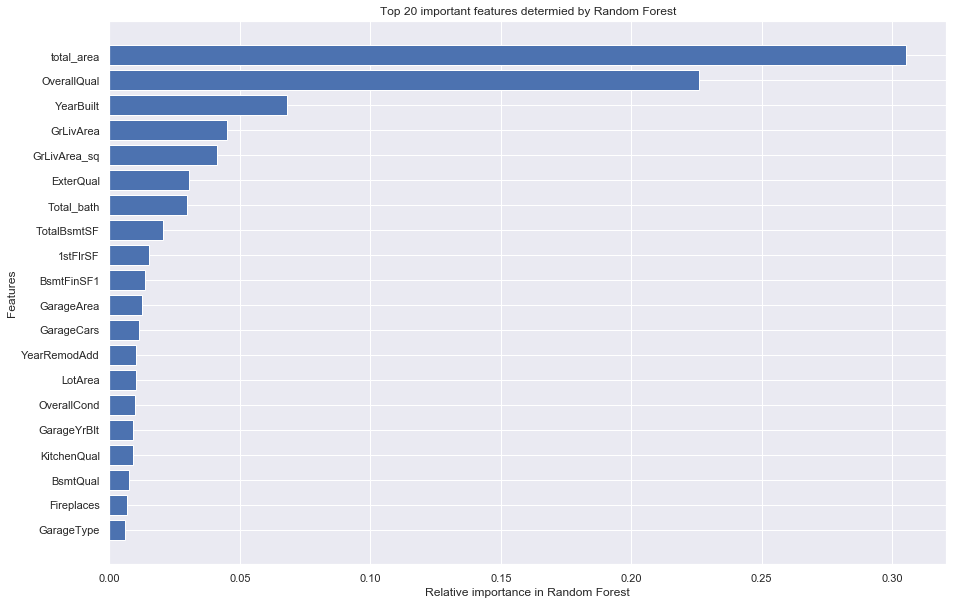

In [98]:
rf_imp_df = pd.DataFrame({'feature_imp':rfmodelCV.feature_importances_, 'Feature_name': X_train.columns}).sort_values(by='feature_imp', ascending=False).iloc[:20]
plt.figure(figsize=(15,10))
plt.barh(rf_imp_df['Feature_name'][::-1],rf_imp_df['feature_imp'][::-1],align='center')
plt.xlabel('Relative importance in Random Forest')
plt.ylabel('Features')
plt.title('Top 20 important features determied by Random Forest')
plt.show()

## Stacked models

In [99]:
from mlxtend.regressor import StackingCVRegressor, StackingRegressor
from mlxtend.plotting import plot_learning_curves

In [108]:
stack = StackingCVRegressor(regressors=(xgbCV,enet_final, ridge_final, lasso_final),
                            meta_regressor=lasso_final, use_features_in_secondary=False,
                            random_state=10, n_jobs=-1)

print('5-fold cross validation scores:\n')

for clf, label in zip([xgbCV,enet_final, ridge_final, lasso_final, stack], ['XGBoost', 'Elastic Net', 'Ridge', 'Lasso', 
                                                'StackingCVRegressor (Lasso)']):
    scores = cross_val_score(clf, X_train.values, y_train.values, cv=5,scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(np.abs(scores))
    print("RMSE: %0.4f (+/- %0.4f) [%s]" % (rmse_scores.mean(), rmse_scores.std(), label))

5-fold cross validation scores:

RMSE: 0.1185 (+/- 0.0092) [XGBoost]
RMSE: 0.1122 (+/- 0.0072) [Elastic Net]
RMSE: 0.1131 (+/- 0.0086) [Ridge]
RMSE: 0.1127 (+/- 0.0071) [Lasso]
RMSE: 0.1104 (+/- 0.0077) [StackingCVRegressor (Lasso)]


In [109]:
stack.fit(X_train,y_train)

StackingCVRegressor(cv=5,
                    meta_regressor=Lasso(alpha=0.0005, copy_X=True,
                                         fit_intercept=True, max_iter=5000,
                                         normalize=False, positive=False,
                                         precompute=False, random_state=10,
                                         selection='cyclic', tol=0.0001,
                                         warm_start=False),
                    n_jobs=-1, pre_dispatch='2*n_jobs', random_state=10,
                    refit=True,
                    regressors=(XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_byleve...
                                Ridge(alpha=5, copy_X=True, fit_intercept=True,
                                      max_iter=5000, normalize=False,
                                      random_state=123, solver='auto',
                                      tol=0.001),
                           

## Final predictions

In [110]:
print(rmsle(np.exp(xgb.predict(X_test)), np.exp(y_test)))
print(rmsle(np.exp(rfmodelCV.predict(X_test)), np.exp(y_test)))
print(rmsle(np.exp(lasso_final.predict(X_test.values)), np.exp(y_test)))
print(rmsle(np.exp(ridge_final.predict(X_test.values)), np.exp(y_test)))
print(rmsle(np.exp(enet_final.predict(X_test.values)), np.exp(y_test)))
print(rmsle(np.exp(stack.predict(X_test.values)), np.exp(y_test)))

0.11624558948781544
0.129972388040507
0.11191983837431844
0.1148165341391344
0.11312929383693922
0.11044054388692105


In [111]:
xgb_pred = np.exp(xgb.predict(test))
rf_pred = np.exp(rfmodelCV.predict(test))
lasso_pred = np.exp(lasso_final.predict(test))
ridge_pred = np.exp(ridge_final.predict(test))
enet_pred = np.exp(enet_final.predict(test))
stack_pred = np.exp(stack.predict(test.values))

In [104]:
#final_pred = np.mean([xgb_pred, stack_pred, lasso_pred, ridge_pred],axis=0,dtype=np.float64)
ensemble1_pred = (0.6*stack_pred + 0.4*lasso_pred)
ensemble2_pred =(0.2*stack_pred + 0.8*lasso_pred)
ensemble3_pred =(0.3*stack_pred + 0.3*lasso_pred + 0.4*xgb_pred)
ensemble4_pred =(0.5*stack_pred + 0.5*lasso_pred)
final_pred = ensemble4_pred

In [105]:
submission = pd.concat([test_id,pd.Series(final_pred, name='SalePrice')],axis=1)
submission.to_csv("final_pred.csv", index = False)